# 0. Load data

In [1]:
import math 
import collections
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv("data/KPIs_with_metrics.csv")
df.head()

,DL_TRAFFIC_VOLUME,UL_TRAFFIC_VOLUME,Inter_X2_based_HO_prep,VoLTE_total_traffic,INTRA_FREQ_HO_SR_RATIO,RRC_SR_RATIO,CELL_AVAILABILITY_RATIO,RACH_Stp_Completion_SR_RATIO,Inter_RAT_HO_SR_UTRAN_SRVCC_RATIO,E_RAB_QCI1_DR_RATIO,...,E_UTRAN_Inter_Freq_HO_SR_RATIO,Inter_RAT_HO_SR_GERAN_SRVCC_RATIO,Inter_RAT_Total_HO_SR_RATIO,E_UTRAN_tot_HO_SR_inter_eNB_X2_RATIO,E_RAB_DR_RATIO,HOUR,cell,IF_score,VAE_loss,VAE_IF_score
0,3.779737e+10,3.947172e+09,15.0,4727.0,0.809859,0.992427,1.0,0.962688,0.576414,0.000000,...,0.770642,0.963636,0.963636,0.400000,0.001761,0,0,0.512958,0.954808,0.485250
1,3.684898e+10,4.088752e+09,6.0,3076.0,0.886792,0.993288,1.0,0.973207,0.576414,0.000000,...,0.842105,1.000000,1.000000,0.500000,0.002468,1,0,0.485098,0.733583,0.484717
2,3.292677e+10,5.016897e+09,8.0,3501.0,0.938356,0.994664,1.0,0.966330,0.000000,0.013889,...,0.931624,1.000000,0.966667,0.375000,0.003077,2,0,0.536488,1.408995,0.585586
3,3.021547e+10,5.139107e+09,9.0,2275.0,0.860215,0.994819,1.0,0.943216,0.576414,0.000000,...,0.816901,0.947368,0.947368,0.777778,0.001721,3,0,0.509256,0.401727,0.489061
4,3.082176e+10,4.250716e+09,17.0,2178.0,0.840426,0.995952,1.0,0.936256,0.576414,0.000000,...,0.794521,1.000000,1.000000,0.764706,0.002213,4,0,0.489774,0.398755,0.487014


In [3]:
metrics = ['IF_score','VAE_loss','VAE_IF_score']

In [4]:
df_features = df.drop(metrics,axis=1)

# 1. Visualize the outcome of each metric

## 1.1 Distribution of 3 metrics value

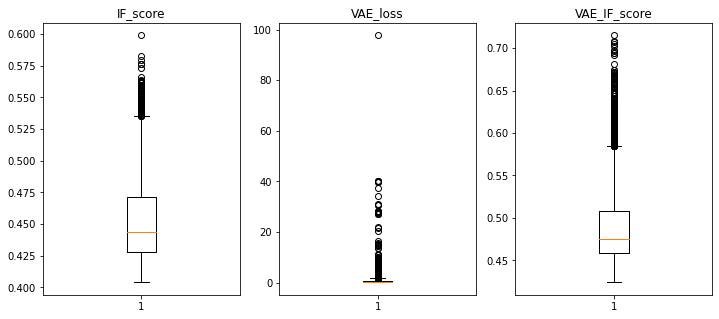

In [5]:
fig = plt.figure(figsize=(12,5))
for i in range(len(metrics)):
    axes = plt.subplot(1,3,i+1)
    axes.boxplot(df[metrics[i]])
    axes.set_title(metrics[i])
plt.show()

## 1.2 Relation between metric value and data point

In [6]:
def anomaly_visualization(df_features,df_metric,title_name,drop_extreme=0):
    """
    Visualize anomalies in 2D/3D scatter plot  
    """
    index = df_features.index
     
    # recude the dimension for visualization
    X_3d = pd.DataFrame(PCA(3).fit_transform(df_features),index=index)
    X_2d = pd.DataFrame(PCA(2).fit_transform(df_features),index=index)
    
    
    if drop_extreme:
        # Drop extreme values
        matric_index = df_metric.argsort()
        index_to_keep = matric_index[:int(len(matric_index)*(1-drop_extreme))]
        df_metric = df_metric[index_to_keep]
    
        # drop corresponding data
        X_3d = X_3d.iloc[index_to_keep]
        X_2d = X_2d.iloc[index_to_keep]
    
    # plot
    fig = plt.figure(figsize=(10,5))
    # 3D
    ax1 = fig.add_subplot(121,  projection='3d')
    ax1.scatter(X_3d.loc[:,0],X_3d.loc[:,1],X_3d.loc[:,2],
                s=4,lw=1,c=df_metric*10,alpha=0.5,
                cmap='rocket_r')
    ax1.set_title(title_name + "(3D)")
    # 2D
    ax2 = fig.add_subplot(133)
    ax2.scatter(X_2d.loc[:,0],X_2d.loc[:,1],
                c=df_metric*10,
                s=5,alpha=0.8,
                cmap='rocket_r')
    ax2.set_title(title_name+"(2D)")
    plt.show()

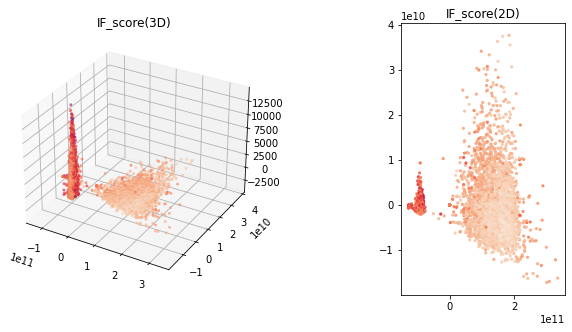

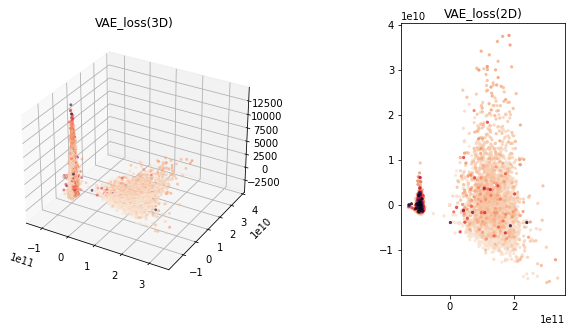

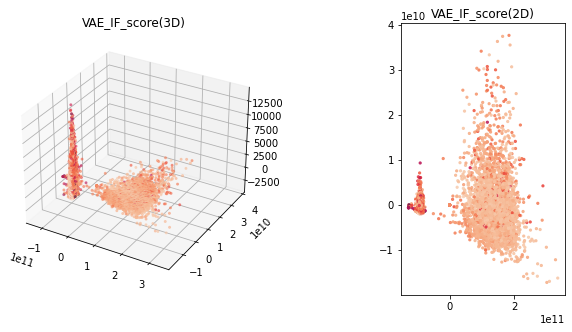

In [7]:
# we keep 99% quantile value in `VAE_loss` since there are very extreme value
drop_extremes = [0, 0.01, 0] 

for metric,drop_extreme in zip(metrics,drop_extremes):
    anomaly_visualization(df.drop(metrics,axis=1),df[metric],metric,drop_extreme)

In the above figure, we compressed the original 20-dimensional data to 2~3 dimensions respectively for visualization. Where the darker color indicates the higher possibility of anomaly. It can be seen that.
- **Isolation Forest** is good at finding out the data edges as well as very small clusters.
- **VAE** is very sensitive to clustering who is far away from majority
- **VAE+IF**: the difference in values is relatively small, but we can still find some points at the edges where the possibility of anomalies is high

# 2. Relation of three indicators

In [8]:
df_matrics = df[metrics]
df_matrics.head()

,IF_score,VAE_loss,VAE_IF_score
0,0.512958,0.954808,0.485250
1,0.485098,0.733583,0.484717
2,0.536488,1.408995,0.585586
3,0.509256,0.401727,0.489061
4,0.489774,0.398755,0.487014


In [9]:
import matplotlib.pyplot as plt 

def matrics_vistualization(df_metrics):
    
    vae_index = df_metrics['VAE_loss'].argsort()
    index_to_keep = vae_index[:int(len(vae_index)*0.99)]
    df_metrics = df_metrics.iloc[index_to_keep]
    
    fig = plt.figure(figsize=(8,8))
    ax = plt.gca()
    ax.scatter(df_metrics['IF_score'],df_metrics['VAE_IF_score'],
                s=8,alpha=0.9,c=df_metrics['VAE_loss'],cmap="rocket_r")
    ax.axvline(df_metrics['IF_score'].quantile(0.9),
               c='black',ls='--',alpha=0.5, label="95% quantile")
    ax.axhline(df_metrics['VAE_IF_score'].quantile(0.95),
               c='black',ls='--',alpha=0.5)
    ax.set_xlabel('IF_score')
    ax.set_ylabel('VAE_IF_score')
    ax.set_title('Matrics of 3 different models \n' + 'color indicates `VAE_loss` (the darker the higher)')
    plt.legend()
    plt.show()

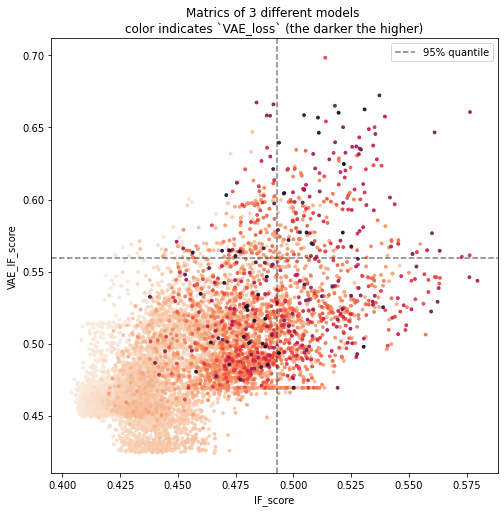

In [10]:
matrics_vistualization(df_matrics)

It can be seen that：
1. In the lower left corner of the image ( x∈[0, 0.45] and y∈[0, 0.55] )
    the values of all three indicators are low, which means that it is less likely to be an outlier
    
2. In the upper part of the image (y>0.6) as well as in the right part (x>0.525), the value of `VAE_loss` seems to be higher, but it is not significant.
    But when both `IF_score` and `VAE_IF_score` have higher scores, `VAE_loss` also tends to have higher values (i.e., all three metrics are considered more likely to be anomalous)
    
3. x∈[0.46, 0.51] and y∈[0.47, 0.56] 
    `VAE_IF_loss` indicates high loss, but for the other two indicators, the same conclusion is not always reached

 # 3. Identification of anomalies - IQR method

## 3.1 Anomaly percentage (per model)

In [11]:
# columns to use later
IQR_thresholds = []
IQR_cols_names = []

In [12]:
def get_IQRfense(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    thresh = Q3 + 1.5*IQR
    return thresh

In [13]:
print("The threshold caculated by IQR method")
print("- "*28)
print("Metric \t\tThreshold \tCorresponding Quantile")
for metric in metrics:
    iqr_thresh = get_IQRfense(df[metric])
    IQR_thresholds.append(iqr_thresh)
    reverse_quantile = stats.percentileofscore(df[metric],iqr_thresh)
    print(f'{metric}: \t{iqr_thresh:.2f} \t\t{reverse_quantile:.2f}%')


The threshold caculated by IQR method
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Metric 		Threshold 	Corresponding Quantile
IF_score: 	0.54 		98.90%
VAE_loss: 	1.65 		91.94%
VAE_IF_score: 	0.58 		97.26%


That is, if we use the IQR method to calculate the threshold for determining whether a sample is anomalous or not, then for each of the three models mentioned above, the proportion of outliers we obtain is 1.10%, 8.06% and 2.74%

It can be seen that the result obtained using a combination of the two models (IF + VAE) is between that of Isolation Forest and VAE. 

## 3.2  Bagging Method

### (1) Record points that exceed the threshold

IQR = Q3 - Q1

upper_bound = Q3 + 1.5\*IQR

lower_bound = Q1 - 1.5\*IQR (this will not be used, since the lower the metric value is, the less possible a record will be an anomaly) 

value > upper_bound are considered as anomaly

In [14]:
for i in range(len(metrics)):
    metric = metrics[i]
    IQR_col = "IQR_outiler_"+metric
    IQR_cols_names.append(IQR_col)
    df[IQR_col] = df[metric].map(lambda x: 1 if x>IQR_thresholds[i] else 0)

In [15]:
df.head()

,DL_TRAFFIC_VOLUME,UL_TRAFFIC_VOLUME,Inter_X2_based_HO_prep,VoLTE_total_traffic,INTRA_FREQ_HO_SR_RATIO,RRC_SR_RATIO,CELL_AVAILABILITY_RATIO,RACH_Stp_Completion_SR_RATIO,Inter_RAT_HO_SR_UTRAN_SRVCC_RATIO,E_RAB_QCI1_DR_RATIO,...,E_UTRAN_tot_HO_SR_inter_eNB_X2_RATIO,E_RAB_DR_RATIO,HOUR,cell,IF_score,VAE_loss,VAE_IF_score,IQR_outiler_IF_score,IQR_outiler_VAE_loss,IQR_outiler_VAE_IF_score
0,3.779737e+10,3.947172e+09,15.0,4727.0,0.809859,0.992427,1.0,0.962688,0.576414,0.000000,...,0.400000,0.001761,0,0,0.512958,0.954808,0.485250,0,0,0
1,3.684898e+10,4.088752e+09,6.0,3076.0,0.886792,0.993288,1.0,0.973207,0.576414,0.000000,...,0.500000,0.002468,1,0,0.485098,0.733583,0.484717,0,0,0
2,3.292677e+10,5.016897e+09,8.0,3501.0,0.938356,0.994664,1.0,0.966330,0.000000,0.013889,...,0.375000,0.003077,2,0,0.536488,1.408995,0.585586,1,0,1
3,3.021547e+10,5.139107e+09,9.0,2275.0,0.860215,0.994819,1.0,0.943216,0.576414,0.000000,...,0.777778,0.001721,3,0,0.509256,0.401727,0.489061,0,0,0
4,3.082176e+10,4.250716e+09,17.0,2178.0,0.840426,0.995952,1.0,0.936256,0.576414,0.000000,...,0.764706,0.002213,4,0,0.489774,0.398755,0.487014,0,0,0


### (2) Count the number of times where the threshold is exceeded

In [16]:
df['IQR_anomaly_record'] = df[["IQR_outiler_IF_score","IQR_outiler_VAE_loss"]].sum(axis=1)
df['IQR_anomaly_record'].value_counts()/df.shape[0]

0    0.916053
1    0.076338
2    0.007610
Name: IQR_anomaly_record, dtype: float64

This means that if there are `n` model(s) that consider a sample to be an outlier, we judge it to be an anomaly, and then the relationship between `n` and the proportion of anomalous samples is:

- `n` = 1 : **8.4%**, that is, the "union" of the 2 models' results
- `n` = 2 : **0.76%**, that is, the "intersection" of the 2 models' results

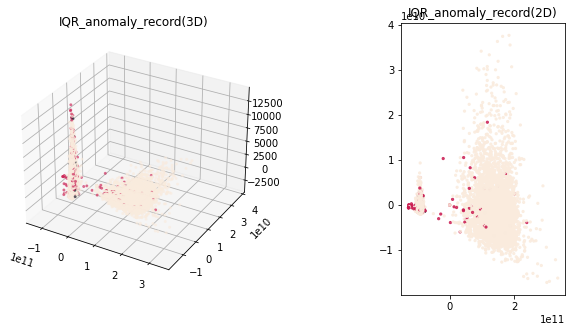

In [19]:
anomaly_visualization(df_features,df['IQR_anomaly_record'],'IQR_anomaly_record')

# 4. Save results

In [18]:
df.to_csv("data/KPIs_with_results.csv",index=None)